In [3]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import src.Fluid_CP as FCP
import src.Compressormodel_SP as CSP
from scipy.integrate import odeint


1. Simulate the pasta cooking step of the pasta cooker to determine the required specifications of the heat pump
• Determine the required heating power during the pasta cooking phase.
• Determine the maximum condenser heat transfer area, considering space limitations
in the pasta cooker.
• Develop an on/off control strategy for the heat pump that keeps the water
temperature within the allowed range.

Optimization success: True
Optimal heat pump power Q (W): 3268.8702231486445


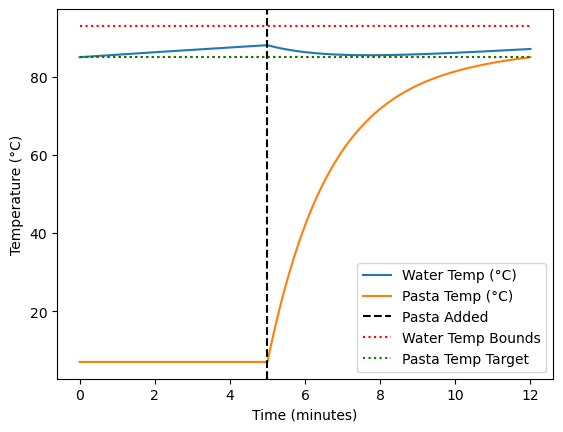

In [14]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint

# Constants and parameters (as you have)
tc_s = 12*60          # total cooking time seconds
tb_s = 5*60          # pasta added after 5 min
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta

V_water = (47-0.4)*(27-0.4)*(20-0.2)/1e6  # m3
m_water = V_water * 1000                   # kg
m_pasta = 2                              # kg

T_env = 20
T_water_0 = 85
T_pasta_0 = 7

dt = 1  # 1 second timestep
time_steps = int(tc_s/dt) + 1
t = np.linspace(0, tc_s, time_steps)

# Simulation function: returns arrays T_water, T_pasta for a given Q (W)
def simulate_temps(Q):
    T_water = np.zeros(time_steps)
    T_pasta = np.zeros(time_steps)
    T_water[0] = T_water_0
    T_pasta[0] = T_pasta_0

    C_water = m_water * c_l
    C_pasta = m_pasta * c_pasta

    for i in range(1, time_steps):
        
        if t[i] <= tb_s:
            # no pasta yet
            dT_water = dt * (Q - (T_water[i-1] - T_env)/R_env) / C_water
            T_water[i] = T_water[i-1] + dT_water
            T_pasta[i] = T_pasta[i-1]
        else:
            # pasta added
            dT_water = dt * (Q - (T_water[i-1] - T_env)/R_env - (T_water[i-1] - T_pasta[i-1])/R_pasta) / C_water
            dT_pasta = dt * ((T_water[i-1] - T_pasta[i-1]) / R_pasta) / C_pasta
            T_water[i] = T_water[i-1] + dT_water
            T_pasta[i] = T_pasta[i-1] + dT_pasta

    return T_water, T_pasta

# Objective function to minimize total energy input: power * time (kJ)
def objective(x):
    Q = x[0]
    # total energy input in kJ: W * s / 1000
    energy_kJ = Q * tc_s / 1000
    return energy_kJ

# Constraint: water temp between 85 and 93 °C AFTER 5 min
def water_temp_constraint(x):
    Q = x[0]
    T_water, _ = simulate_temps(Q)
    idx_start = int(tb_s/dt)

    # We want: 85 <= T_water <= 93 for all t >= 5 min
    # Return minimum margin: min(T_water - 85), min(93 - T_water)
    # Both must be >= 0 to satisfy constraints

    min_lower = np.min(T_water[idx_start:] - 85)  # should be >=0
    min_upper = np.min(93 - T_water[idx_start:])  # should be >=0
    return np.array([min_lower, min_upper])

# Constraint: pasta temp at 7 min >= 85
def pasta_temp_constraint(x):
    Q = x[0]
    _, T_pasta = simulate_temps(Q)
    return T_pasta[-1] - 85  # >= 0

# Setup nonlinear constraints using scipy's NonlinearConstraint
NC_water = NonlinearConstraint(water_temp_constraint, [0, 0], [np.inf, np.inf])
NC_pasta = NonlinearConstraint(pasta_temp_constraint, 0, np.inf)

constraints = [NC_water, NC_pasta]

# Bounds for Q: 0 (OFF) to 5000 W max
bounds = [(0, 5000)]

# Initial guess
x0 = [3000]

# Run optimization
result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)

print("Optimization success:", result.success)
print("Optimal heat pump power Q (W):", result.x[0])

# Optional: simulate temperatures for final Q
T_water_final, T_pasta_final = simulate_temps(result.x[0])

import matplotlib.pyplot as plt

plt.plot(t/60, T_water_final, label='Water Temp (°C)')
plt.plot(t/60, T_pasta_final, label='Pasta Temp (°C)')
plt.axvline(x=5, color='k', linestyle='--', label='Pasta Added')
plt.hlines([85, 93], 0, 12, colors='r', linestyles='dotted', label='Water Temp Bounds')
plt.hlines(85, 0, 12, colors='g', linestyles='dotted', label='Pasta Temp Target')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()
